# Qiskit- Tutorial 5

Reference : 

* https://github.com/Qiskit/qiskit-tutorials/blob/master/legacy_tutorials/terra/5_using_the_transpiler.ipynb?fbclid=IwAR3JRCVnsAZWFqpIqDaLssGbIxru-2qrwN8MR0gesUe6X0ZSp0ALeXL1Wgk

* https://qiskit-staging.mybluemix.net/documentation/terra/transpiler/getting_started.html#getting-started-with-the-transpiler

In [3]:
import numpy as np
#from qiskit import *
from qiskit import QuantumCircuit, execute, Aer, IBMQ

from qiskit.visualization import plot_histogram, plot_gate_map, plot_circuit_layout
from qiskit.tools.monitor import job_monitor

import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')

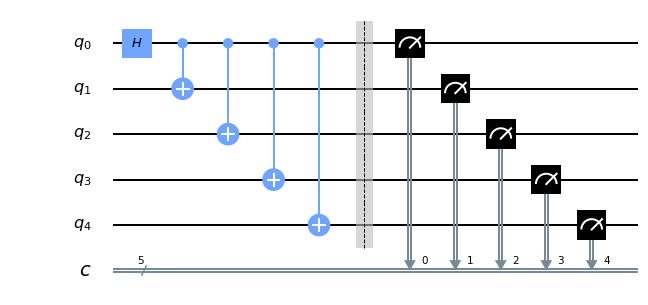

In [26]:
ghz = QuantumCircuit(5,5)
ghz.h(0)
for idx in range(1,5):
    ghz.cx(0,idx)
ghz.barrier(range(5))
ghz.measure(range(5), range(5))
ghz.draw(output='mpl')


In [7]:
from qiskit import transpile
import inspect
inspect.signature(transpile)

<Signature (circuits, backend=None, basis_gates=None, coupling_map=None, backend_properties=None, initial_layout=None, seed_transpiler=None, optimization_level=None, pass_manager=None, callback=None, output_name=None)>

In [8]:
provider = IBMQ.get_provider(group='open')
provider.backends(simulator=False)

[<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_rome') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [9]:
backend = provider.get_backend('ibmqx2')
backend.configuration().basis_gates

['u1', 'u2', 'u3', 'cx', 'id']

The u* gates represent arbitrary single-qubit rotations of one, two, and three angles. The u1 gates are single-parameter rotations that represent generalized phase gates of the form

$$
U_{1}(\lambda) =
    \begin{bmatrix}
    1  \ \ 0 \\
    0  \ \ e^{i\lambda}
    \end{bmatrix}
$$

This set includes common gates such as $Z$, $T$, $T^{\dagger}$, $S$, and $S^{\dagger}$. It turns out that these gates do not actually need to be performed on hardware, but instead, can be implemented in software as "virtual gates". These virtual gates are called "frame changes" and take zero time, and have no associated error; they are free gates on hardware.

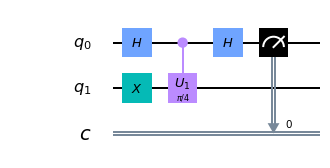

In [17]:
qc = QuantumCircuit(2,1)
qc.h(0)
qc.x(1)
qc.cu1(np.pi/4, 0, 1)  
# cu1 is controlled u1 just like CNOT is controlled NOT
qc.h(0)
qc.measure([0], [0])
qc.draw(output='mpl')

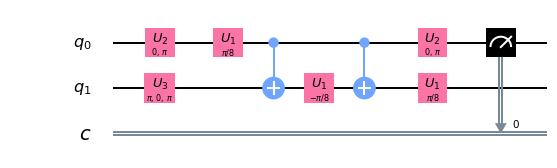

In [18]:
qc_basis = qc.decompose()
qc_basis.draw(output='mpl')

In [19]:
print(qc.depth(), ',', qc_basis.depth())

4 , 7


## SWAP Gate Decomposition

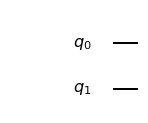

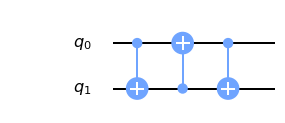

In [21]:
swap_circ = QuantumCircuit(2)
display ( swap_circ.draw(output='mpl') )
swap_circ.swap(0, 1)
display  ( swap_circ.decompose().draw(output='mpl') )

As a product of three CNOT gates, SWAP gates are expensive operations to perform on a noisy quantum devices. However, such operations are usually necessary for embedding a circuit into the limited entangling gate connectivities of actual devices. Thus, minimizing the number of SWAP gates in a circuit is a primary goal in the transpilation process.

## Toffoli Gate Decomposition

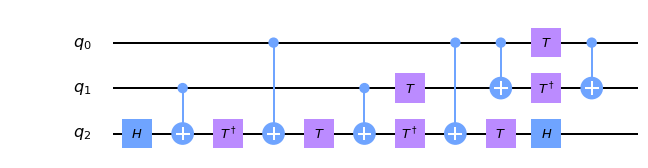

In [22]:
ccx_circ = QuantumCircuit(3)
ccx_circ.ccx(0, 1, 2)
ccx_circ.decompose().draw(output='mpl')

For every Toffoli gate in a quantum circuit, the IBM Q hardware may execute up to six CNOT gates, and a handful of single-qubit gates. From this example, it should be clear that any algorithm that makes use of multiple Toffoli gates will end up as a circuit with large depth and will therefore be appreciably affected by noise and gate errors.



## Initial Layout

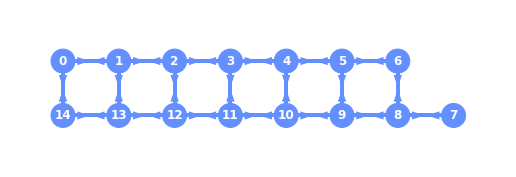

In [27]:
backend = provider.get_backend('ibmq_16_melbourne')
plot_gate_map(backend, plot_directed=True)

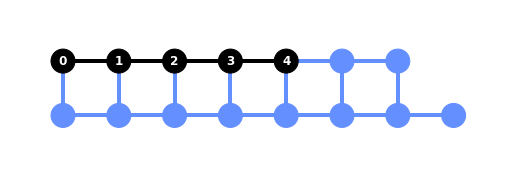

In [28]:
new_circ_lv0 = transpile(ghz, backend=backend, optimization_level=0)
plot_circuit_layout(new_circ_lv0, backend )

Depth: 9


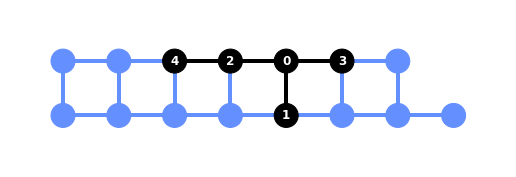

In [29]:
backend = provider.get_backend('ibmq_16_melbourne')
new_circ_lv3 = transpile(ghz, backend=backend, optimization_level=3)

print('Depth:', new_circ_lv3.depth())
plot_circuit_layout(new_circ_lv3, backend)

In [31]:
#job1 = execute(new_circ_lv3, backend)
#job_monitor(job1)

## Specifying an Initial layout

In [ ]:
# Virtual -> physical
#    0    ->    11
#    1    ->    12
#    2    ->    10
#    3    ->    2
#    4    ->    4

good_ghz = transpile(ghz, backend, initial_layout=[11,12,10,2,4])
print('Depth:', good_ghz.depth())
plot_circuit_layout(good_ghz, backend)